# 在GooLeNet中使用批量规范化

## 1 加载相关库

In [1]:
import torch
import torchvision
from torch import nn
from IPython import display
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## 2 使用自定义的BatchNorm来训练GoogLeNet

### 2.1 自定义Batch Norm函数

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps = 1e-5, momentum = 0.9):
    if not torch.is_grad_enabled():  ##评估模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:  ##训练模式
        assert len(X.shape) in (2, 4), "输入数据的形状不符合要求"
        if len(X.shape) == 2:
            #全连接层的情况
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim = 0)
        if len(X.shape) == 4:
            #卷积层的情况
            mean = X.mean(dim = (0 ,2 ,3), keepdim = True)
            var = ((X - mean) ** 2).mean(dim = (0 ,2 ,3), keepdim = True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = moving_mean * momentum + mean * (1.0 - momentum)
        moving_var = moving_var * momentum + var * (1.0 - momentum)
    Y = gamma * X_hat + beta
    
    return Y, moving_mean.data, moving_var.data

### 2.2 自定义BatchNorm类

In [3]:
class BatchNorm(nn.Module):
    # num_features：全连接层的输出数量和卷积层的输出通道数。
    # num_dims：2表示全连接层，4表示卷积层。
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸参数和偏执参数，其分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # 如果X不在内存上,将moving_mean和moving_var复制到X所在的显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, 
                                                          eps = 1e-5, momentum = 0.9)
        return Y

In [4]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # 第一条路径
        self.p1_1 = nn.Conv2d(in_channels = in_channels, out_channels = c1, kernel_size = 1)
        self.p1_2 = BatchNorm(c1, 4)
        # 第二条路径
        self.p2_1 = nn.Conv2d(in_channels = in_channels, out_channels = c2[0], kernel_size = 1)
        self.p2_2 = BatchNorm(c2[0], 4)
        self.p2_3 = nn.Conv2d(in_channels = c2[0], out_channels = c2[1], kernel_size = 3, padding = 1, stride = 1)
        self.p2_4 = BatchNorm(c2[1], 4)
        # 第三条路径
        self.p3_1 = nn.Conv2d(in_channels = in_channels, out_channels = c3[0], kernel_size = 1)
        self.p3_2 = BatchNorm(c3[0], 4)
        self.p3_3 = nn.Conv2d(in_channels = c3[0], out_channels = c3[1], kernel_size = 5, padding = 2, stride = 1)
        self.p3_4 = BatchNorm(c3[1], 4)
        # 第四条路径
        self.p4_1 = nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 1)
        self.p4_2 = nn.Conv2d(in_channels = in_channels, out_channels = c4, kernel_size = 1)
        self.p4_3 = BatchNorm(c4, 4)
    
    def forward(self, x):
        # 第一条路径
        
        p1 = F.relu(self.p1_2(self.p1_1(x)))
        # 第二条路经
        p2 = F.relu(self.p2_4(self.p2_3(F.relu(self.p2_2(self.p2_1(x))))))
        # 第三条路径
        p3 = F.relu(self.p3_4(self.p3_3(F.relu(self.p3_2(self.p3_1(x))))))
        # 第四条路径
        p4 = F.relu(self.p4_3(self.p4_2(self.p4_1(x))))
        
        return torch.cat((p1, p2, p3, p4), dim = 1)

In [5]:
b1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 2, padding = 3), 
                   BatchNorm(64, 4), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1), 
                   BatchNorm(64, 4), nn.ReLU(), 
                   nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, stride = 1, padding = 1), 
                   BatchNorm(192, 4), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32), 
                   Inception(256, 128, (128, 192), (32, 96), 64), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64), 
                   Inception(512, 160, (112, 224), (24, 64), 64), 
                   Inception(512, 128, (128, 256), (24, 64), 64), 
                   Inception(512, 112, (144, 288), (32, 64), 64), 
                   Inception(528, 256, (160, 320), (32, 128), 128), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128), 
                   Inception(832, 384, (192, 384), (48, 128), 128), 
                   nn.AdaptiveAvgPool2d((1, 1)), 
                   nn.Flatten())

In [6]:
net1 = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [7]:
x = torch.rand(size=(1, 1, 96, 96))
for layer in net1:
    x = layer(x)
    print(layer.__class__.__name__, "output_shape:\t", x.shape)

Sequential output_shape:	 torch.Size([1, 64, 24, 24])
Sequential output_shape:	 torch.Size([1, 192, 12, 12])
Sequential output_shape:	 torch.Size([1, 480, 6, 6])
Sequential output_shape:	 torch.Size([1, 832, 3, 3])
Sequential output_shape:	 torch.Size([1, 1024])
Linear output_shape:	 torch.Size([1, 10])


## 3 动态绘图

In [8]:
def plot_image(num, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc):
    plt.figure(num = num)
    plt.ion()
    plt.cla()
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax1.grid(ls='-.')
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.plot(range(i + 1), val_loss_his, label='val_loss')
    ax1.legend()
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    ax2.grid(ls='-.')
    ax2.set_xlim(0, num_epochs)
    ax2.set_ylim(0, 1)
    ax2.plot(range(i + 1), train_his_acc, label='train_accuracy')
    ax2.plot(range(i + 1), val_his_acc, label='val_accuracy')
    ax2.legend()
    display.clear_output(wait=True)
    plt.pause(0.0000001)
    plt.ioff()
    plt.show()

## 4 训练模型

In [9]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize([96, 96])])
mnist_train = torchvision.datasets.FashionMNIST(root = "C:/Users/CCU6/Practice/pytorch/data", train = True,
                                                transform = trans, download = True)
mnist_test = torchvision.datasets.FashionMNIST(root = "C:/Users/CCU6/Practice/pytorch/data", train = False,
                                                transform = trans, download = True)

### 4.1 将网络参数用xavier初始化

In [10]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

### 4.2 训练函数
- 这里面使用了小批量梯度下降，如果不用批量梯度下降的话（其他参数不变），网络就会不收敛，准确率一直在0.1附近。或者是训练更多轮。

In [11]:
def train_model(net, num_epochs, alpha, device, batch_size):
    #定义的东西
    train_loss_his = []
    val_loss_his = []
    train_his_acc = []
    val_his_acc = []
    train_data_batch = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 0)
    val_data_batch = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = True, num_workers = 0)
    #正式代码
    net.apply(init_weight)
    print(f"train on:{device}")
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = alpha)
    loss = nn.CrossEntropyLoss(reduction='none')
    for i in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        net.train()
        #每次迭代用batch_size大小的数据集进行训练，一轮共every_num_epoch此迭代。
        for k, (data_train, label_train) in enumerate(train_data_batch):
            data_train_k = data_train.to(device)
            label_train_k = label_train.to(device)
            optimizer.zero_grad()
            y_trian_hat = net(data_train_k)
            l_train = loss(y_trian_hat, label_train_k)
            l_train.mean().backward()
            optimizer.step()
            with torch.no_grad():
                train_max_hat = torch.argmax(y_trian_hat, dim = 1)
                train_acc_k = sum(train_max_hat == label_train_k)
                train_acc += train_acc_k
                train_loss += l_train.sum()
        
        net.eval()
        with torch.no_grad():
            val_loss = 0.
            val_acc = 0.
            #验证集的预测
            for data_val, label_val in val_data_batch:
                data_val_k = data_val.to(device)
                label_val_k = label_val.to(device)
                y_val_hat = net(data_val_k)
                val_max_hat = torch.argmax(y_val_hat, dim = 1)
                val_acc_k = sum(val_max_hat == label_val_k)
                l_val = loss(y_val_hat, label_val_k)
                val_acc += val_acc_k
                val_loss += l_val.sum()
            
            train_loss_his.append(((train_loss * 1.0)/len(mnist_train)).cpu())
            val_loss_his.append(((val_loss * 1.0)/len(mnist_test)).cpu())
            train_his_acc.append(((train_acc * 1.0)/len(mnist_train)).cpu())
            val_his_acc.append(((val_acc * 1.0)/len(mnist_test)).cpu())
        #画出每次迭代的图
        plot_image(2, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc)
    print(f"train acc:{max(train_his_acc)}, test acc:{max(val_his_acc)}")
    
    return train_loss_his, val_loss_his, train_his_acc, val_his_acc

In [12]:
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 10, 0.02, 128

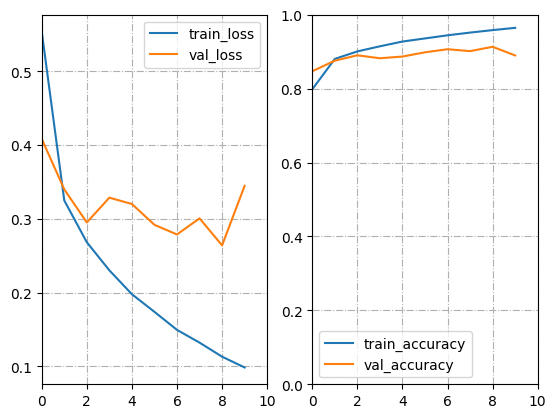

train acc:0.9643333554267883, test acc:0.913100004196167


In [13]:
train_loss_his, test_loss_his, train_his_acc, test_his_acc = train_model(net1, num_epochs, alpha, device, batch_size)

## 5 使用torch中的BatchNorm

### 5.1 自定义Inception类

In [14]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # 第一条路径
        self.p1_1 = nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = c1, kernel_size = 1), nn.BatchNorm2d(c1))
        # 第二条路径
        self.p2_1 =  nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = c2[0], kernel_size = 1), nn.BatchNorm2d(c2[0]))
        self.p2_2 =  nn.Sequential(nn.Conv2d(in_channels = c2[0], out_channels = c2[1], kernel_size = 3, padding = 1, stride = 1), 
                                   nn.BatchNorm2d(c2[1]))
        # 第三条路径
        self.p3_1 =  nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = c3[0], kernel_size = 1), nn.BatchNorm2d(c3[0]))
        self.p3_2 =  nn.Sequential(nn.Conv2d(in_channels = c3[0], out_channels = c3[1], kernel_size = 5, padding = 2, stride = 1), 
                                   nn.BatchNorm2d(c3[1]))
        # 第四条路径
        self.p4_1 =  nn.Sequential(nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 1), 
                                   nn.Conv2d(in_channels = in_channels, out_channels = c4, kernel_size = 1), 
                                   nn.BatchNorm2d(c4))
    
    def forward(self, x):
        # 第一条路径
        p1 = F.relu(self.p1_1(x))
        # 第二条路经
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        # 第三条路径
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        # 第四条路径
        p4 = F.relu(self.p4_1(x))
        
        return torch.cat((p1, p2, p3, p4), dim = 1)

### 5.2 定义GooLeNET网络

In [15]:
b1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 2, padding = 3), 
                   nn.BatchNorm2d(64), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1), 
                   nn.BatchNorm2d(64), nn.ReLU(), 
                   nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, stride = 1, padding = 1), 
                   nn.BatchNorm2d(192), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32), 
                   Inception(256, 128, (128, 192), (32, 96), 64), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64), 
                   Inception(512, 160, (112, 224), (24, 64), 64), 
                   Inception(512, 128, (128, 256), (24, 64), 64), 
                   Inception(512, 112, (144, 288), (32, 64), 64), 
                   Inception(528, 256, (160, 320), (32, 128), 128), 
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128), 
                   Inception(832, 384, (192, 384), (48, 128), 128), 
                   nn.AdaptiveAvgPool2d((1, 1)), 
                   nn.Flatten())

In [16]:
net2 = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [17]:
x = torch.rand(size=(1, 1, 96, 96))
for layer in net2:
    x = layer(x)
    print(layer.__class__.__name__, "output_shape:\t", x.shape)

Sequential output_shape:	 torch.Size([1, 64, 24, 24])
Sequential output_shape:	 torch.Size([1, 192, 12, 12])
Sequential output_shape:	 torch.Size([1, 480, 6, 6])
Sequential output_shape:	 torch.Size([1, 832, 3, 3])
Sequential output_shape:	 torch.Size([1, 1024])
Linear output_shape:	 torch.Size([1, 10])


In [18]:
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 10, 0.02, 128

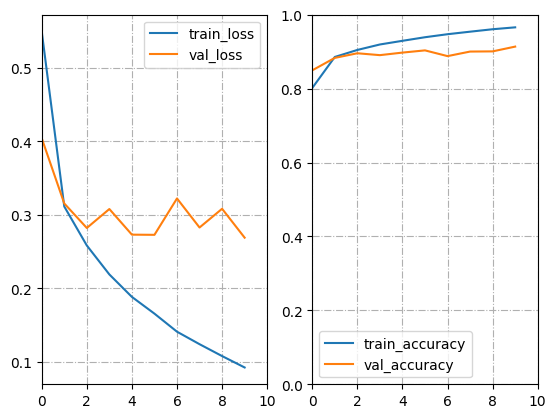

train acc:0.9657333493232727, test acc:0.913599967956543


In [19]:
train_loss_his, test_loss_his, train_his_acc, test_his_acc = train_model(net2, num_epochs, alpha, device, batch_size)